In [1]:
# 基础包
import pandas as pd
import numpy as np
import pickle # 打包数据

# BOW处理
from tox21_project import data_preprocessing as dp

# sklearn数据预处理
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# xgboost 和 RandomForest 模型
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier

# 模型的测试
from tox21_project import testing

D:\Anaconda3-2021-11\envs\pytorch\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1. 数据准备

### 1.1 数据的导入

In [2]:
source = pd.read_csv('data/data_dups_removed.csv', index_col=0)
source.head()

,Formula,FW,DSSTox_CID,SR-HSE,ID,SMILES,Molecule,NR-AR,SR-ARE,NR-Aromatase,NR-ER-LBD,NR-AhR,SR-MMP,NR-ER,NR-PPAR-gamma,SR-p53,SR-ATAD5,NR-AR-LBD
0,C27H25ClN6,468.9806,25848,0.0,NCGC00178831-03,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.Nc1ccc2cc3ccc(N...,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN
1,C20H6Br4Na2O5,691.8542,5234,0.0,NCGC00166114-03,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN
2,C47H83NO17,934.1584,28909,0.0,NCGC00263563-01,CO[C@H]1CC(O[C@H]2C[C@H]([C@H]3O[C@](C)(O)[C@H...,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0
3,C52H54N4O12,927.0048,5513,1.0,NCGC00013058-02,CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)c...,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN
4,C66H87N17O14,1342.5025,26683,NaN,NCGC00167516-01,CC(=O)O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=...,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
features = ['FW', 'SMILES']
targets = ['SR-HSE',
          'NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',
          'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD']
raw_X, raw_y = source[features], source[targets]

### 1.2 NULL值处理

In [4]:
# NULL的mask为0
null_mask = np.array(np.logical_not(raw_y.isnull().values), int)
null_mask

array([[1, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [5]:
raw_y = raw_y.fillna(0.0)

给raw_Y后面插上null_mask

In [6]:
mask_df = pd.DataFrame(null_mask, columns=[i + '_mask' for i in raw_y.columns], index=raw_y.index)
raw_y = pd.concat([raw_y, mask_df], axis=1)

### 1.3 数据分割

In [7]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(raw_X, raw_y, test_size=test_size, random_state=42)
y_train, mask_train = y_train[targets], y_train[mask_df.columns]
y_test, mask_test = y_test[targets], y_test[mask_df.columns]

### 1.4 数据转化为BOW

In [8]:
smiles = X_train['SMILES']
bow = dp.BagOfWords(smiles)
bow_train = bow.fit()
bow_test = bow.transform(X_test['SMILES'])

In [9]:
bow_train = np.insert(bow_train, 0, X_train['FW'], axis=1)
bow_test = np.insert(bow_test, 0, X_test['FW'], axis=1)

In [10]:
bow_train.shape

(5385, 56)

### 1.5 数据标准化

In [11]:
scaler = StandardScaler() # 针对列来做归一化
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)
X_train, X_test = bow_train, bow_test

## 2. 训练

### 2.1 随机森林 训练

In [12]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
pickle.dump(rf_model, open('models/rf_benchmark.pkl', 'wb'))

### 2.2 XGBoost 训练

In [13]:
# MultiOutputClassifier 用于扩展本身不支持多目标分类的分类器
# use_label_encoder 是否使用xgb训练时候的编码标签
xgb_model = MultiOutputClassifier(xgb.XGBClassifier(eval_metric=['logloss','auc','error'], use_label_encoder=False))
xgb_model.fit(X_train, y_train)
pickle.dump(xgb_model, open('models/xgb_benchmark.pkl', 'wb'))

## 3. 测试

In [14]:
def get_pred_and_scores(model, X):
    pred = model.predict(X)
    scores = np.array([model.predict_proba(X)[i][:, 1] for i in range(12)]).T # 返回一个三维的list，2，3维为0，1的可能性
    return pred, scores

### 3.1 XGBoost 测试

训练集

In [15]:
# 计算pred和scores
y_pred, y_scores = get_pred_and_scores(xgb_model, X_train)
# 计算指标
xgb_train_panel = testing.panel_of_test(targets, y_train.values, mask_train.values)
xgb_train_panel.compute_basic_metrics(y_pred, y_scores)

  0%|          | 0/12 [00:00<?, ?it/s]

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,0.99435,0.67433,0.803653,0.957037,0.980565,0.837045,0.995227
NR-AR,0.988571,0.816038,0.894057,0.986112,0.991813,0.90781,0.999258
SR-ARE,0.9825,0.609302,0.752153,0.945199,0.935201,0.803607,0.982493
NR-Aromatase,0.994083,0.823529,0.900804,0.994826,0.990757,0.911633,0.9997
NR-ER-LBD,0.994286,0.707317,0.826603,0.966188,0.984709,0.853548,0.997613
NR-AhR,0.995181,0.789675,0.880597,0.983596,0.975061,0.894585,0.997209
SR-MMP,0.989899,0.76087,0.860404,0.979341,0.96015,0.879688,0.995211
NR-ER,0.975779,0.523191,0.681159,0.917353,0.937677,0.760649,0.983259
NR-PPAR-gamma,1.0,0.782946,0.878261,0.984732,0.993682,0.891473,0.999284
SR-p53,1.0,0.762069,0.864971,0.989588,0.985177,0.881034,0.999104


测试集

In [16]:
# 计算pred和scores
y_pred, y_scores = get_pred_and_scores(xgb_model, X_test)
# 计算指标
xgb_test_panel = testing.panel_of_test(targets, y_test.values, mask_test.values)
xgb_test_metrics = xgb_test_panel.compute_basic_metrics(y_pred, y_scores)
xgb_test_metrics

  0%|          | 0/12 [00:00<?, ?it/s]

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,0.52381,0.09322,0.158273,0.206151,0.946527,0.544195,0.723278
NR-AR,0.792453,0.428571,0.556291,0.548508,0.972709,0.711952,0.806395
SR-ARE,0.671053,0.157895,0.255639,0.429698,0.848392,0.571307,0.753342
NR-Aromatase,0.666667,0.11215,0.192,0.265358,0.948417,0.554454,0.761685
NR-ER-LBD,0.627907,0.243243,0.350649,0.384426,0.957609,0.618063,0.763576
NR-AhR,0.705882,0.273764,0.394521,0.513226,0.90045,0.629217,0.845283
SR-MMP,0.702899,0.326599,0.445977,0.580313,0.87622,0.650875,0.863433
NR-ER,0.635135,0.180769,0.281437,0.358892,0.885387,0.583024,0.69302
NR-PPAR-gamma,0.5,0.066667,0.117647,0.12432,0.97235,0.532385,0.723231
SR-p53,0.521739,0.085106,0.146341,0.242256,0.938353,0.539971,0.778932


In [17]:
print(xgb_test_metrics.to_markdown())

|               |   Precision |    Recall |       F1 |    AUPRC |   Accuracy |   Balanced Accuracy |   ROC_AUC |
|:--------------|------------:|----------:|---------:|---------:|-----------:|--------------------:|----------:|
| SR-HSE        |    0.52381  | 0.0932203 | 0.158273 | 0.206151 |   0.946527 |            0.544195 |  0.723278 |
| NR-AR         |    0.792453 | 0.428571  | 0.556291 | 0.548508 |   0.972709 |            0.711952 |  0.806395 |
| SR-ARE        |    0.671053 | 0.157895  | 0.255639 | 0.429698 |   0.848392 |            0.571307 |  0.753342 |
| NR-Aromatase  |    0.666667 | 0.11215   | 0.192    | 0.265358 |   0.948417 |            0.554454 |  0.761685 |
| NR-ER-LBD     |    0.627907 | 0.243243  | 0.350649 | 0.384426 |   0.957609 |            0.618063 |  0.763576 |
| NR-AhR        |    0.705882 | 0.273764  | 0.394521 | 0.513226 |   0.90045  |            0.629217 |  0.845283 |
| SR-MMP        |    0.702899 | 0.326599  | 0.445977 | 0.580313 |   0.87622  |            0.6508

In [18]:
xgb_test_metrics.to_csv('data/xgb_metrics.csv')

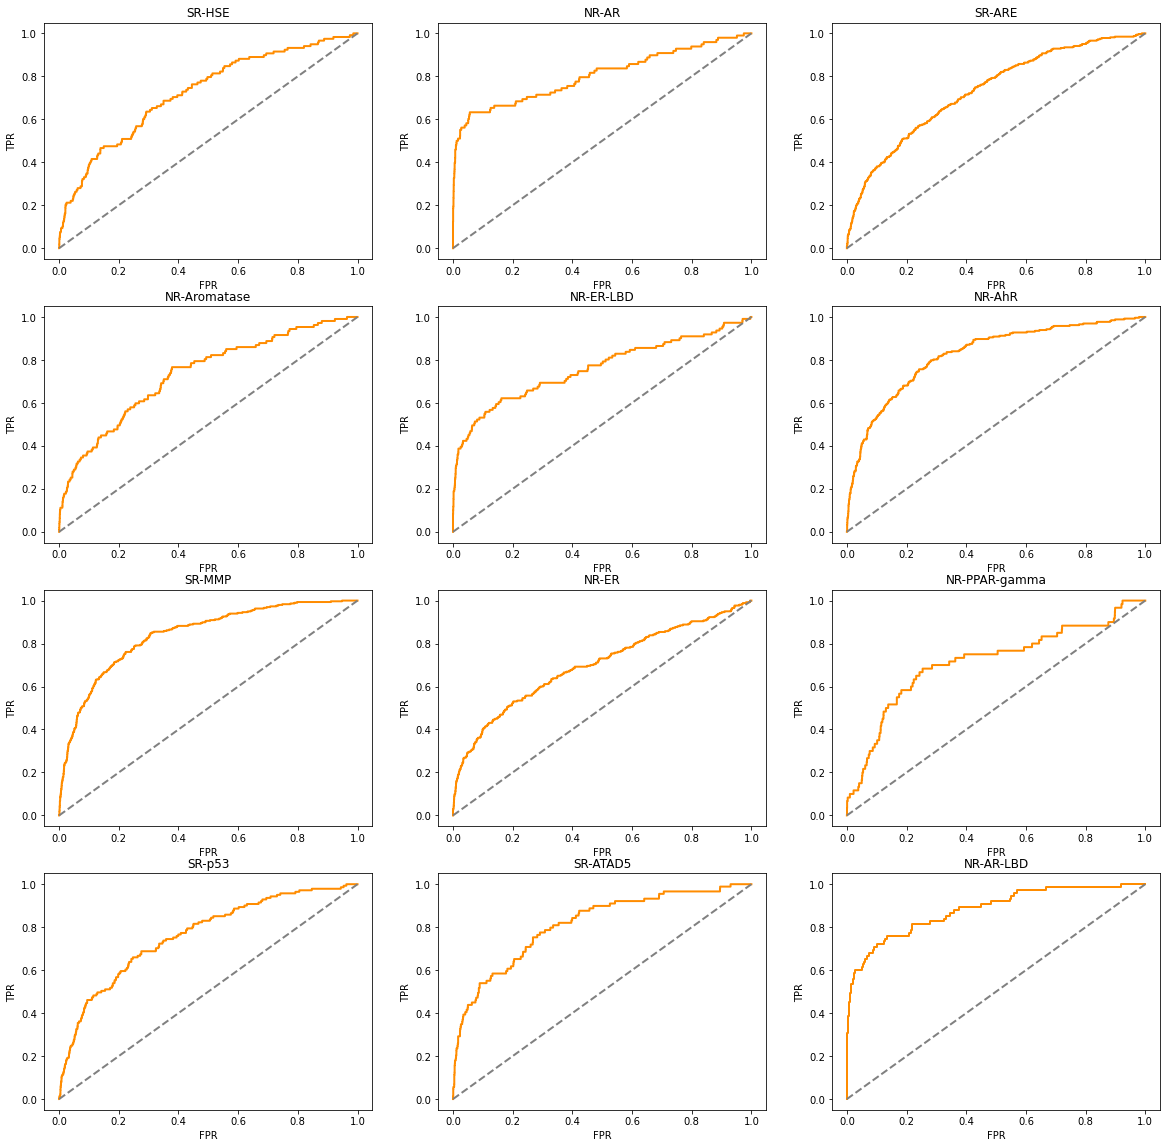

In [19]:
# 画图
xgb_test_panel.plot_roc(y_scores)

### 3.2 随机森林 测试

训练集

In [20]:
# 计算pred和scores
y_pred, y_scores = get_pred_and_scores(rf_model, X_train)
# 计算指标
rf_train_panel = testing.panel_of_test(targets, y_train.values, mask_train.values)
rf_train_panel.compute_basic_metrics(y_pred, y_scores)

  0%|          | 0/12 [00:00<?, ?it/s]

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,1.0,0.938697,0.968379,0.997911,0.996384,0.969349,0.999874
NR-AR,1.0,0.957547,0.978313,0.998985,0.998203,0.978774,0.999959
SR-ARE,0.99359,0.96124,0.977147,0.998161,0.992745,0.980023,0.999672
NR-Aromatase,0.995025,0.980392,0.987654,0.999622,0.998751,0.990064,0.999983
NR-ER-LBD,0.995726,0.947154,0.970833,0.998583,0.997067,0.973467,0.999927
NR-AhR,0.994094,0.965583,0.979631,0.999263,0.995324,0.982414,0.999907
SR-MMP,0.995231,0.97205,0.983504,0.99935,0.994737,0.985577,0.999877
NR-ER,0.993915,0.909091,0.949612,0.99455,0.987724,0.95414,0.999192
NR-PPAR-gamma,1.0,0.953488,0.97619,0.998711,0.998646,0.976744,0.999967
SR-p53,0.996491,0.97931,0.987826,0.999566,0.998496,0.989541,0.999974


测试集

In [21]:
# 计算pred和scores
y_pred, y_scores = get_pred_and_scores(rf_model, X_test)
# 计算指标
rf_test_panel = testing.panel_of_test(targets, y_test.values, mask_test.values)
rf_test_metrics = rf_test_panel.compute_basic_metrics(y_pred, y_scores)
rf_test_metrics

  0%|          | 0/12 [00:00<?, ?it/s]

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,0.4,0.033898,0.0625,0.190948,0.945155,0.5155,0.737
NR-AR,0.803922,0.418367,0.550336,0.523565,0.972709,0.707062,0.805185
SR-ARE,0.694915,0.126935,0.21466,0.455964,0.846861,0.557966,0.782138
NR-Aromatase,0.6,0.056075,0.102564,0.288739,0.946374,0.526957,0.784229
NR-ER-LBD,0.7,0.252252,0.370861,0.414161,0.959729,0.623457,0.790096
NR-AhR,0.780488,0.243346,0.371014,0.530833,0.902252,0.617074,0.855347
SR-MMP,0.732143,0.276094,0.400978,0.610641,0.874165,0.628956,0.879781
NR-ER,0.5625,0.173077,0.264706,0.352279,0.880611,0.576996,0.675641
NR-PPAR-gamma,0.5,0.033333,0.0625,0.161326,0.97235,0.516193,0.794297
SR-p53,0.583333,0.049645,0.091503,0.250953,0.938793,0.523649,0.771661


In [22]:
print(rf_test_metrics.to_markdown())

|               |   Precision |    Recall |        F1 |    AUPRC |   Accuracy |   Balanced Accuracy |   ROC_AUC |
|:--------------|------------:|----------:|----------:|---------:|-----------:|--------------------:|----------:|
| SR-HSE        |    0.4      | 0.0338983 | 0.0625    | 0.190948 |   0.945155 |            0.5155   |  0.737    |
| NR-AR         |    0.803922 | 0.418367  | 0.550336  | 0.523565 |   0.972709 |            0.707062 |  0.805185 |
| SR-ARE        |    0.694915 | 0.126935  | 0.21466   | 0.455964 |   0.846861 |            0.557966 |  0.782138 |
| NR-Aromatase  |    0.6      | 0.0560748 | 0.102564  | 0.288739 |   0.946374 |            0.526957 |  0.784229 |
| NR-ER-LBD     |    0.7      | 0.252252  | 0.370861  | 0.414161 |   0.959729 |            0.623457 |  0.790096 |
| NR-AhR        |    0.780488 | 0.243346  | 0.371014  | 0.530833 |   0.902252 |            0.617074 |  0.855347 |
| SR-MMP        |    0.732143 | 0.276094  | 0.400978  | 0.610641 |   0.874165 |         

In [23]:
rf_test_metrics.to_csv('data/rf_metrics.csv')

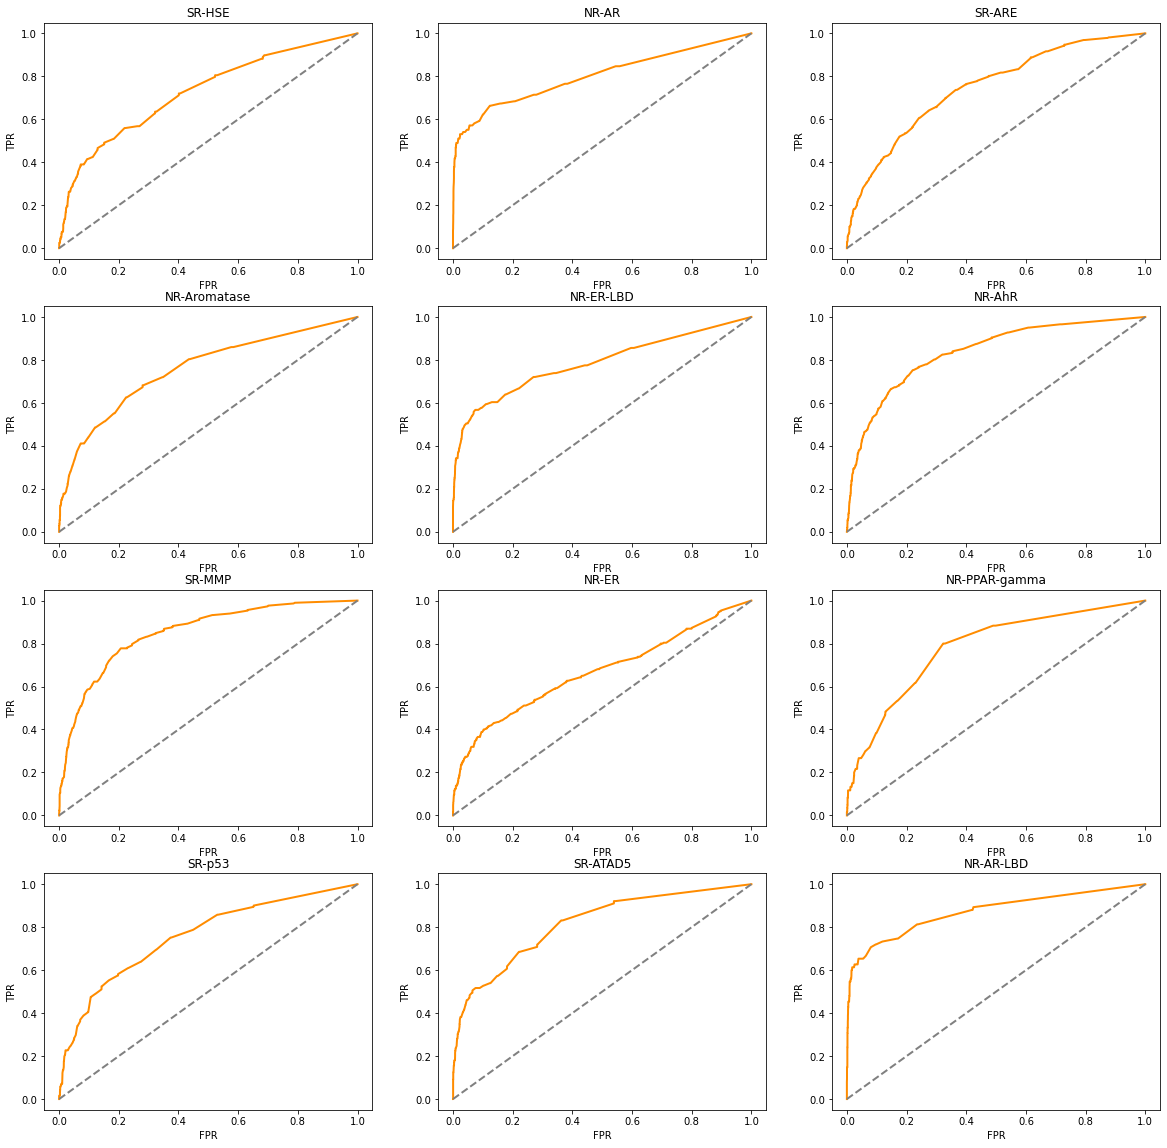

In [24]:
# 画图
rf_test_panel.plot_roc(y_scores)

## 4. 总结

In [25]:
res = pd.DataFrame(index = ['Precision', 'Recall', 'F1', 'AUPRC', 'Accuracy', 'Balanced Accuracy','ROC_AUC'])

def f(x):
    if x:
        return 'RF'
    else:
        return 'XGB'

applymap和apply的区别：[here](https://zhuanlan.zhihu.com/p/100064394)

In [26]:
# applymap 对 DataFrame 逐元素调用函数
(rf_test_metrics > xgb_test_metrics).applymap(lambda x: f(x))

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,XGB,XGB,XGB,XGB,XGB,XGB,RF
NR-AR,RF,XGB,XGB,XGB,XGB,XGB,XGB
SR-ARE,RF,XGB,XGB,RF,XGB,XGB,RF
NR-Aromatase,XGB,XGB,XGB,RF,XGB,XGB,RF
NR-ER-LBD,RF,RF,RF,RF,RF,RF,RF
NR-AhR,RF,XGB,XGB,RF,RF,XGB,RF
SR-MMP,RF,XGB,XGB,RF,XGB,XGB,RF
NR-ER,XGB,XGB,XGB,XGB,XGB,XGB,XGB
NR-PPAR-gamma,XGB,XGB,XGB,RF,XGB,XGB,RF
SR-p53,RF,XGB,XGB,RF,RF,XGB,XGB
